In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch._C import device
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# assert torch.cuda.is_available()

# Problem 1
Download the CIFAR10 training and test datasets.
Transform them into tensors, normalize them as described above in the code, and create DataLoaders for each one. 
For the training set, use a batch size of 32, and for the test set, use a batch size of 1.

In [2]:
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')

# Nomalize and transform into tensotr
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download the CIFAR10 training data to ../data
train_data = datasets.CIFAR10('../data', train=True, 
                              download=True, transform=transform)

test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# Create a DataLoader from the shuffled training data
train_loader = DataLoader(train_data, batch_size=36, shuffle=True)

test_loader = DataLoader(test_data)

# Get the 36 images of size 3x32x32 and labels in the first batch
dataiter = iter(train_loader)
images, labels = dataiter.next()


images.size()

Files already downloaded and verified
Files already downloaded and verified


torch.Size([36, 3, 32, 32])

# Problem 2

Create a convolution model class convoles an image of size $3\times 32 \times 32$ into a 1D tensor that represents the $10$ classes.
The model should have at least three convolution layers, each followed by an activation function, and include at least two linear layers and one maxpool layer.
Select channels and kernel sizes so that you get at least $50,000$ parameters.

Calculate and print the number of learnable parameters in your model.

Initialize your model and move it to the device.
Run the model on a single image to make sure there are no errors.


In [3]:
class ConvolutionModel(nn.Module): 
  def __init__(self):
    super(ConvolutionModel, self).__init__()
    # Initialize the layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) #6x28x28
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) # in:6x14x14 out:16x10x10
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=3) # 10x4x4
    self.flatten = nn.Flatten() # 1x(10*5*5)
    self.linear1 = nn.Linear(in_features=10 * 4 * 4, out_features=12) # 250x10
    self.linear2 = nn.Linear(in_features=12, out_features=10) # 1x10
  
  # Call the layers on an image
  def forward(self, x):
    output = self.relu(self.conv1(x))
    output = self.maxpool(output) 
    output = self.relu(self.conv2(output))
    output = self.maxpool(output)
    output = self.relu(self.conv3(output)) 
    output = self.flatten(output)
    output = self.relu(self.linear1(output))
    return self.linear2(output)

In [4]:
model = ConvolutionModel()
# model = model.to(device)

m = model(images[0]. unsqueeze(0))

# Problem 3

Train the model by looping through the training data. Inside the loop, you should
1. Zero out the gradients.
2. Run the model on the inputs.
3. Calculate the loss on the model output and the actual label.
4. Backpropogate the error.
5. Optimize.

Run the loop for 10 epochs. At the end of each epoch, calculate the mean loss of the
training data for that epoch. Then calculate the accuracy of the model on the test data. Since
the model is no longer training, it needs to be set to evaluation mode using model.eval().
To resume training at the beginning of the next epoch, set the model to training mode using
model.train().

You should have around $50\%$ accuracy at the end of $10$ epochs.

Plot the epochs v. mean training loss each epoch and the epochs v. accuracy.


In [11]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
train_loss_list = []
accuracies = []

loop = tqdm(total=len(train_loader), position=0)

for epoch in range(epochs):
  train_loss = 0.0
  # test_loss = 0.0

  ## Train model
  model.train()
  for data, target in train_loader:
    optimizer.zero_grad()
    output = model(data)
    loss = objective(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)

    loop.set_description('loss:{:.4f}'.format(loss.item()))
    loop.update()
  
  model.eval()
  accuracy = 0
  for data, target in test_loader:
    output = model(data)
    # calculate the batch loss
    if torch.argmax(output) == target:
      accuracy += 1
  

  train_loss = train_loss / len(train_loader.dataset)
  accuracy = accuracy / len(test_loader.dataset)

  train_loss_list.append(train_loss)
  accuracies.append(accuracy)

  print('Epoch: {} \tTraining Loss: {:.6f} \test Accuracy: {:.6f}'.format(
        epoch, train_loss, accuracy))


loss:0.9798: : 8334it [07:04, 19.65it/s]
loss:1.5563: : 1395it [00:48,  1.67it/s]

Epoch: 0 	Training Loss: 1.441175 	est Accuracy: 0.475900


loss:1.4362: : 2784it [01:36,  1.23it/s]

Epoch: 1 	Training Loss: 1.431198 	est Accuracy: 0.474200


loss:1.5824: : 4173it [02:25,  1.66it/s]

Epoch: 2 	Training Loss: 1.420441 	est Accuracy: 0.482500


loss:1.5945: : 5562it [03:12,  1.66it/s]

Epoch: 3 	Training Loss: 1.411361 	est Accuracy: 0.487900


loss:1.2658: : 6951it [04:01,  1.21it/s]

Epoch: 4 	Training Loss: 1.400473 	est Accuracy: 0.490000


loss:1.3047: : 8341it [04:49,  1.69it/s]

Epoch: 5 	Training Loss: 1.392118 	est Accuracy: 0.495400


loss:1.0729: : 9729it [05:38,  1.69it/s]

Epoch: 6 	Training Loss: 1.383126 	est Accuracy: 0.497200


loss:1.8066: : 11118it [06:26,  1.69it/s]

Epoch: 7 	Training Loss: 1.375991 	est Accuracy: 0.499700


loss:1.0227: : 12507it [07:15,  1.24it/s]

Epoch: 8 	Training Loss: 1.367515 	est Accuracy: 0.502300


loss:1.3175: : 13889it [07:52, 37.83it/s]

Epoch: 9 	Training Loss: 1.359520 	est Accuracy: 0.507600


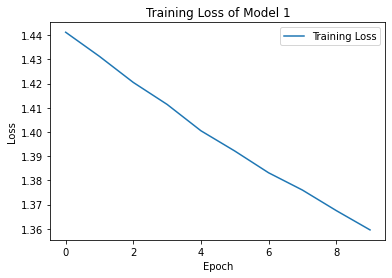

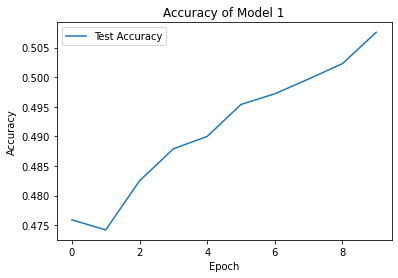

In [13]:
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss of Model 1")

plt.legend()
plt.show()

plt.plot(accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy of Model 1")

plt.legend()
plt.show()

# Problem 4

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [14]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, -1, 1)

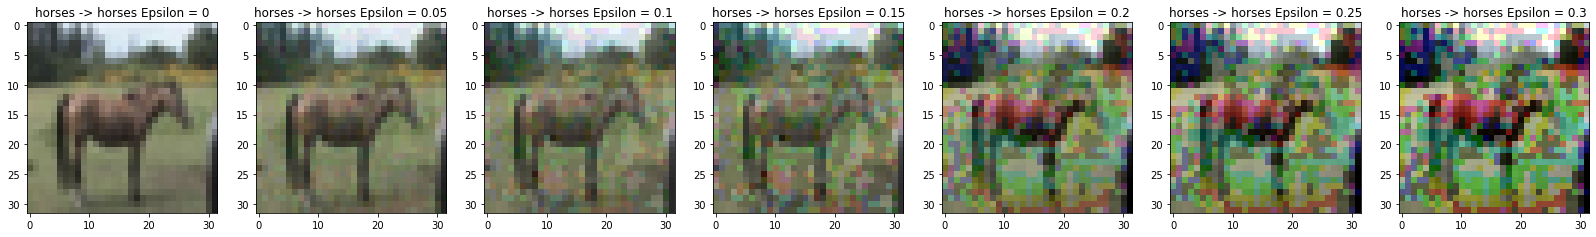

In [22]:
# def Adversarial_Attack(model, data_loader, eps):
accuracies = []
model.eval()
fig, axs = plt.subplots(1, 7, figsize=(28, 4))
for i, eps in enumerate([0, .05, .1, .15, .2, .25, .3]):
  accuracy = 0
  for batch, (x, y) in enumerate(test_loader):
    # x, y = x.to(device), y.to(device)
    x.requires_grad = True
    y_hat = model(x)
    if torch.argmax(y_hat) != y:
      continue
    loss = objective(y_hat, y) # Update loss
    optimizer.zero_grad() # Zero out gradients
    loss.backward() # Backwards step
    optimizer.step()
    data_grad = x.grad.data

    perturbed_data = fgsm_attack(x, eps, data_grad)

    output = model(perturbed_data)
    if torch.argmax(output) == y:
      accuracy += 1
  accuracies.append(accuracy / len(test_loader))

  ex = perturbed_data.squeeze().detach().cpu().numpy()
  # Plot the image
  img = ex / 2 + 0.5 # unnormalize
  axs[i].imshow(np.transpose(img, (1, 2, 0)))
  axs[i].set_title(classes[y[0]] + " -> " + classes[torch.argmax(output[0])] + " Epsilon = " + str(eps))
plt.show()
